# Magnetic Reference Layer (MRL) Optimization - Presentation

This notebook demonstrates the optimization of a Magnetic Reference Layer (MRL) and Capping Layer structure for Polarized Neutron Reflectometry (PNR). The optimization uses a **two-stage approach**:

1. **Evolutionary Algorithm (Differential Evolution)**: Global search to explore the entire parameter space
2. **L-BFGS-B Algorithm**: Local refinement to converge to the optimal solution

**Important Note**: The physical layer stack (Silicon substrate → MRL → Capping layer → SOI) is **defined in the problem class** and cannot be modified by users. This notebook optimizes the **thicknesses** of these layers for a **fixed Co:Ti composition**.

## 1. Setup and Imports

Import necessary libraries for optimization and visualization.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
import time

sys.path.append(os.path.abspath("../"))

from problems.base1 import Base1OptimizationProblem, Materials, MRL, Bounds, SOISpec, CapSpec, SubstrateSpec
from physics.fom import tsf
from physics.reflectometry import reflectivity as refl
from physics.magnetic_sld import coti_magnetic_sld

## 2. Material Definitions

### 2.1 Substrate

**Parameters**:
- `name`: Material identifier ("Si" = Silicon)
- `rho_n`: Nuclear scattering length density (×10⁻⁶ Å⁻²) - determines how neutrons scatter from the material
- `sigma`: Interface roughness (Å) - width of the transition between layers

In [2]:
# Substrate: Silicon wafer (bottom layer of the stack)
sub = SubstrateSpec(
    name="Si",      # Silicon
    rho_n=2.07,     # Nuclear SLD: 2.07 × 10⁻⁶ Å⁻²
    sigma=3.0       # Interface roughness: 3 Ångströms
)

### 2.2 Capping Layer Candidates

The capping layer protects the MRL from oxidation and affects the reflectivity signal. We test **8 different materials** to find the optimal one.

**Parameters for each material**:
- `name`: Material identifier
- `nom_thickness`: Starting thickness (Å) - **this will be optimized**
- `rho_n`: Nuclear scattering length density (×10⁻⁶ Å⁻²)
- `sigma`: Interface roughness with MRL (Å)

In [3]:
# Capping layer candidates - different materials with unique scattering properties
caps = {
    "Al2O3":        CapSpec(name="Al2O3",        nom_thickness=50.0, rho_n=3.5,  sigma=3.0),  # Aluminum oxide
    "Ti":           CapSpec(name="Ti",           nom_thickness=50.0, rho_n=-1.94, sigma=3.0),  # Titanium 
    "MgO":          CapSpec(name="MgO",          nom_thickness=50.0, rho_n=5.38, sigma=3.0),  # Magnesium oxide
    "Au":           CapSpec(name="Au",           nom_thickness=50.0, rho_n=4.5,  sigma=3.0),  # Gold
    "SiO2":         CapSpec(name="SiO2",         nom_thickness=50.0, rho_n=3.4,  sigma=3.0),  # Silicon dioxide
    "TiO2":         CapSpec(name="TiO2",         nom_thickness=50.0, rho_n=2.61, sigma=3.0),  # Titanium dioxide
    "TiO2_anatase": CapSpec(name="TiO2_anatase", nom_thickness=50.0, rho_n=3.65, sigma=3.0),  # TiO2 anatase 
    "TiO2_rutile":  CapSpec(name="TiO2_rutile",  nom_thickness=50.0, rho_n=4.08, sigma=3.0),  # TiO2 rutile (best one)
}

print(f"Testing {len(caps)} capping materials: {', '.join(caps.keys())}")

Testing 8 capping materials: Al2O3, Ti, MgO, Au, SiO2, TiO2, TiO2_anatase, TiO2_rutile


### best from earlier run
1      MgO             0.089010     45.71      16.16      0.000000       
2      Au              0.086366     44.94      18.10      0.000000       
3      TiO2_rutile     0.084650     44.47      20.15      0.000000

In [4]:
caps = {
    "MgO":          CapSpec(name="MgO",          nom_thickness=50.0, rho_n=5.38, sigma=3.0),  # Magnesium oxide
    "Au":           CapSpec(name="Au",           nom_thickness=50.0, rho_n=4.5,  sigma=3.0),  # Gold
    "TiO2_rutile":  CapSpec(name="TiO2_rutile",  nom_thickness=50.0, rho_n=4.08, sigma=3.0),  # TiO2 rutile (best one)
}

### 2.3 Magnetic Reference Layer (MRL)

The MRL is a **Co-Ti alloy** whose magnetic properties depend on composition. The Co:Ti ratio is **FIXED at 0.73** (73% Co, 27% Ti) in this optimization.

**Parameters**:
- `rho_n_Co`: Nuclear SLD of pure Cobalt (×10⁻⁶ Å⁻²)
- `rho_n_Ti`: Nuclear SLD of pure Titanium (×10⁻⁶ Å⁻²) - note the negative value!
- `m_sld_from_x`: Function calculating magnetic SLD from Co fraction
  - Formula: magnetic_SLD = 1.08 × x_CoTi
  - This linear relationship comes from experimental data
- `sigma_sub_mrl`: Roughness at substrate/MRL interface (Å)
- `sigma_mrl_cap`: Roughness at MRL/capping layer interface (Å)

**Note on layer structure**: The order (Si → MRL → Cap → SOI) is **fixed in the problem class** and cannot be changed by users.

In [5]:
# MRL: Cobalt-Titanium magnetic alloy
# Using the new physically accurate magnetic SLD calculation
# that accounts for density changes as Co and Ti mix
mrl = MRL(
    rho_n_Co=1.21,                  # Nuclear SLD of pure Cobalt
    rho_n_Ti=-1.94,                 # Nuclear SLD of pure Titanium (negative!)
    m_sld_from_x=coti_magnetic_sld, # NEW: Physically accurate function from physics.magnetic_sld
    sigma_sub_mrl=5.0,              # Roughness at Si/MRL interface
    sigma_mrl_cap=5.0               # Roughness at MRL/cap interface
)

# Combine all materials
materials = Materials(substrate=sub, caps=caps, mrl=mrl)

print("✓ Materials defined")
print(f"  - Substrate: {sub.name}")
print(f"  - MRL: Co-Ti alloy (composition FIXED at 73% Co, 27% Ti)")
print(f"  - Using NEW physically accurate magnetic SLD calculation")
print(f"  - Capping layers: {len(caps)} candidates to test")

✓ Materials defined
  - Substrate: Si
  - MRL: Co-Ti alloy (composition FIXED at 73% Co, 27% Ti)
  - Using NEW physically accurate magnetic SLD calculation
  - Capping layers: 3 candidates to test


## 3. Samples of Interest (SOI)

These represent different magnetic thin films we want to measure. The MRL/cap structure must provide good sensitivity for **ALL** of these samples.

**SOI Parameters**:
- `name`: Identifier for this sample type
- `rho_n`: Nuclear SLD of the film (×10⁻⁶ Å⁻²)
- `thickness`: Film thickness (Å)
- `sigma`: Roughness at cap/SOI interface (Å)

**Optimization Goal**: Maximize the **sum** of Total Squared Fringe (TSF) scores across all SOIs.

In [6]:
# Define diverse samples to test - wide range of properties
soi_list = [
    # Normal Type: Thickness 500 A, Roughness 15 A
    SOISpec(name="SOI1", rho_n=1.0, thickness=500.0, sigma=15.0),
    SOISpec(name="SOI2", rho_n=2.0, thickness=500.0, sigma=15.0),
    SOISpec(name="SOI3", rho_n=3.0, thickness=500.0, sigma=15.0),

    # Rough Type: Thickness 500 A, Roughness 50 A
    SOISpec(name="SOI4", rho_n=1.0, thickness=500.0, sigma=50.0),
    SOISpec(name="SOI5", rho_n=2.0, thickness=500.0, sigma=50.0),
    SOISpec(name="SOI6", rho_n=3.0, thickness=500.0, sigma=50.0),

    # Thin Type: Thickness 50 A, Roughness 15 A
    SOISpec(name="SOI7", rho_n=1.0, thickness=50.0, sigma=15.0),
    SOISpec(name="SOI8", rho_n=2.0, thickness=50.0, sigma=15.0),
    SOISpec(name="SOI9", rho_n=3.0, thickness=50.0, sigma=15.0)
]

print(f"Optimizing for {len(soi_list)} different SOI types:")
for s in soi_list:
    print(f"  - {s.name:20s}: ρ={s.rho_n:.1f} × 10⁻⁶ Å⁻², d={s.thickness:5.1f} Å, σ={s.sigma:.1f} Å")

Optimizing for 9 different SOI types:
  - SOI1                : ρ=1.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=15.0 Å
  - SOI2                : ρ=2.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=15.0 Å
  - SOI3                : ρ=3.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=15.0 Å
  - SOI4                : ρ=1.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=50.0 Å
  - SOI5                : ρ=2.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=50.0 Å
  - SOI6                : ρ=3.0 × 10⁻⁶ Å⁻², d=500.0 Å, σ=50.0 Å
  - SOI7                : ρ=1.0 × 10⁻⁶ Å⁻², d= 50.0 Å, σ=15.0 Å
  - SOI8                : ρ=2.0 × 10⁻⁶ Å⁻², d= 50.0 Å, σ=15.0 Å
  - SOI9                : ρ=3.0 × 10⁻⁶ Å⁻², d= 50.0 Å, σ=15.0 Å


## 4. Optimization Problem Setup

**Q-grid**: Momentum transfer range for reflectivity calculations
- Range: 0.005 to 0.3 Å⁻¹
- Points: 300 (high resolution)

**Optimization Variables** (what we're optimizing):
1. `d_mrl`: MRL thickness (10-1200 Å) - **TO BE OPTIMIZED**
2. `d_cap`: Capping layer thickness (10-200 Å) - **TO BE OPTIMIZED**
3. `x_CoTi`: Co fraction - **FIXED at 0.73** in this notebook

**Fixed Layer Structure** (defined in the `Base1OptimizationProblem` class):
```
Air/Vacuum
    ↓
SOI (Sample of Interest) ← placed on top by experimentalist
    ↓
Capping Layer ← optimized thickness & material
    ↓
MRL (Co-Ti alloy) ← optimized thickness, fixed 73:27 Co:Ti ratio
    ↓
Si Substrate ← fixed bottom layer
```

**Users cannot change this layer ordering** - it's determined by the experimental physics and defined in the problem class.

In [7]:
# Q-space grid for neutron reflectivity
q_grid = np.linspace(0.005, 0.3, 300)

# Parameter bounds (search space)
bounds_x = Bounds(0, 1)          # Co fraction: 0 to 1 (fixed at 0.73)
bounds_d = Bounds(10, 1200)      # MRL thickness: 10 to 1200 Å
bounds_cap = Bounds(10, 200)     # Cap thickness: 10 to 200 Å

# Create optimization problem
problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=soi_list,
    q_grid=q_grid,
    bounds_x=bounds_x,
    bounds_d=bounds_d,
    bounds_cap=bounds_cap
)

print(" Optimization problem initialized")
print(f"  - Q-range: {q_grid[0]:.3f} to {q_grid[-1]:.3f} Å^-1")
print(f"  - MRL thickness range: {bounds_d.lo:.0f}-{bounds_d.hi:.0f} Å")
print(f"  - Cap thickness range: {bounds_cap.lo:.0f}-{bounds_cap.hi:.0f} Å")
print(f"  - Co fraction: FIXED at 0.73")

 Optimization problem initialized
  - Q-range: 0.005 to 0.300 Å^-1
  - MRL thickness range: 10-1200 Å
  - Cap thickness range: 10-200 Å
  - Co fraction: FIXED at 0.73


## 5. Two-Stage Optimization

### Why Two Stages?

**Stage 1: Differential Evolution (Global Search)**
- **Purpose**: Explore the entire parameter space to find promising regions
- **Algorithm**: Population-based evolutionary algorithm
  - Population size: 25 individuals
  - Strategy: DE/best/1/bin
  - Mutation factor: 0.5-1.0
  - Crossover probability: 0.7
- **Advantage**: Resistant to local minima, finds global basin
- **Time limit**: 2 minutes per capping material

**Stage 2: L-BFGS-B (Local Refinement)**
- **Purpose**: Fine-tune the solution from DE to high precision
- **Algorithm**: Quasi-Newton method (approximates Hessian)
- **Starting point**: Best solution from Stage 1
- **Advantage**: Fast convergence, high precision
- **Tolerances**: ftol=1e-12, gtol=1e-10

### Objective Function
- **Metric**: Total Squared Fringe (TSF)
- **Definition**: Sum of squared sensitivity metrics across all SOIs
- **Goal**: Maximize TSF (higher = better sensitivity to SOI presence)

### Fixed Parameters
- **x_CoTi = 0.73**: Co:Ti composition ratio (from Solver.ipynb pre-value)

In [8]:
# Fixed Co:Ti ratio
FIXED_X_COTI = 0.73  # 73% Co, 27% Ti

# Optimization settings
TIME_BUDGET_S = 2 * 60  # 2 minutes per material
SEED = 42               # For reproducibility

# Storage for results
results_log = []
best_overall = {"score": -np.inf, "cap": None, "d_mrl": 0, "d_cap": 0}

print("="*80)
print("TWO-STAGE OPTIMIZATION")
print("="*80)
print(f"Fixed Co fraction: {FIXED_X_COTI:.2f} (73% Co, 27% Ti)")
print(f"Capping materials to test: {len(caps)}")
print(f"Time budget per material: {TIME_BUDGET_S/60:.0f} minutes")
print("\nStage 1: Differential Evolution (global search)")
print("Stage 2: L-BFGS-B (local refinement)")
print("="*80)

TWO-STAGE OPTIMIZATION
Fixed Co fraction: 0.73 (73% Co, 27% Ti)
Capping materials to test: 3
Time budget per material: 2 minutes

Stage 1: Differential Evolution (global search)
Stage 2: L-BFGS-B (local refinement)


In [9]:
# Run two-stage optimization for each capping material
for cap_name in caps.keys():
    print(f"\n{'='*80}")
    print(f"Optimizing for capping material: {cap_name}")
    print(f"{'='*80}")
    
    # Objective function (minimize negative TSF = maximize TSF)
    def objective_func(x):
        d_mrl_val, d_cap_val = x
        score = problem.evaluate_objective(
            x_coti=FIXED_X_COTI,
            d_mrl=float(d_mrl_val),
            d_cap=float(d_cap_val),
            cap=cap_name
        )
        return -float(score)  # Negative for minimization
    
    # Parameter bounds
    bnds = [
        (bounds_d.lo, bounds_d.hi),      # MRL thickness
        (bounds_cap.lo, bounds_cap.hi),  # Cap thickness
    ]
    
    # Differential Evolution
    print("\n[Stage 1] Differential Evolution (global search)...")
    start_time = time.monotonic()
    
    def stop_if_time_up(xk, convergence):
        return (time.monotonic() - start_time) > TIME_BUDGET_S
    
    de_result = differential_evolution(
        objective_func,
        bounds=bnds,
        strategy="best1bin",
        maxiter=10000,
        popsize=25,
        tol=0.0,
        mutation=(0.5, 1.0),
        recombination=0.7,
        seed=SEED,
        polish=False,
        updating="deferred",
        workers=1,
        callback=stop_if_time_up,
        disp=False
    )
    
    de_score = -float(de_result.fun)
    d_mrl_de, d_cap_de = map(float, de_result.x)
    de_time = time.monotonic() - start_time
    
    print(f"  Completed in {de_time:.1f}s")
    print(f"  DE Score: {de_score:.6f}")
    print(f"  DE Params: d_mrl={d_mrl_de:.2f} Å, d_cap={d_cap_de:.2f} Å")
    
    # L-BFGS-B
    print("\n[Stage 2] L-BFGS-B (local refinement)...")
    lbfgs_start = time.monotonic()
    
    lbfgs_result = minimize(
        objective_func,
        x0=de_result.x,
        method="L-BFGS-B",
        bounds=bnds,
        options={"maxiter": 5000, "ftol": 1e-12, "gtol": 1e-10}
    )
    
    lbfgs_time = time.monotonic() - lbfgs_start
    final_score = -float(lbfgs_result.fun)
    d_mrl_final, d_cap_final = map(float, lbfgs_result.x)
    
    print(f"  Completed in {lbfgs_time:.1f}s")
    print(f"  Final Score: {final_score:.6f} (Δ = {final_score - de_score:.6f})")
    print(f"  Final Params: d_mrl={d_mrl_final:.2f} Å, d_cap={d_cap_final:.2f} Å")
    
    # Store results
    results_log.append({
        "cap": cap_name,
        "score_de": de_score,
        "score_final": final_score,
        "d_mrl": d_mrl_final,
        "d_cap": d_cap_final,
        "x_coti": FIXED_X_COTI,
        "time_de": de_time,
        "time_lbfgs": lbfgs_time
    })
    
    # Update best overall
    if final_score > best_overall["score"]:
        best_overall = {
            "score": final_score,
            "cap": cap_name,
            "d_mrl": d_mrl_final,
            "d_cap": d_cap_final
        }

print(f"\n\n{'='*80}")
print("OPTIMIZATION COMPLETE")
print(f"{'='*80}")
print(f"Best capping material: {best_overall['cap']}")
print(f"Best TSF score: {best_overall['score']:.6f}")
print(f"Optimal MRL thickness: {best_overall['d_mrl']:.2f} Å")
print(f"Optimal cap thickness: {best_overall['d_cap']:.2f} Å")
print(f"Co fraction (fixed): {FIXED_X_COTI:.3f}")
print(f"{'='*80}")


Optimizing for capping material: MgO

[Stage 1] Differential Evolution (global search)...
  Completed in 120.0s
  DE Score: 0.181360
  DE Params: d_mrl=35.09 Å, d_cap=13.36 Å

[Stage 2] L-BFGS-B (local refinement)...
  Completed in 0.1s
  Final Score: 0.181360 (Δ = -0.000000)
  Final Params: d_mrl=35.09 Å, d_cap=13.36 Å

Optimizing for capping material: Au

[Stage 1] Differential Evolution (global search)...
  Completed in 120.1s
  DE Score: 0.170944
  DE Params: d_mrl=34.66 Å, d_cap=16.12 Å

[Stage 2] L-BFGS-B (local refinement)...
  Completed in 0.1s
  Final Score: 0.170944 (Δ = -0.000000)
  Final Params: d_mrl=34.66 Å, d_cap=16.12 Å

Optimizing for capping material: TiO2_rutile

[Stage 1] Differential Evolution (global search)...
  Completed in 38.6s
  DE Score: 0.166081
  DE Params: d_mrl=34.52 Å, d_cap=18.56 Å

[Stage 2] L-BFGS-B (local refinement)...
  Completed in 0.0s
  Final Score: 0.166081 (Δ = 0.000000)
  Final Params: d_mrl=34.52 Å, d_cap=18.56 Å


OPTIMIZATION COMPLETE
Be

## 6. Results Summary

Compare all capping materials ranked by performance.

In [10]:
import pandas as pd

df_results = pd.DataFrame(results_log)
df_results = df_results.sort_values('score_final', ascending=False)

print("\nRankings (sorted by TSF score):")
print("="*100)
print(f"{'Rank':<6} {'Material':<15} {'Final TSF':<12} {'MRL (Å)':<10} {'Cap (Å)':<10} {'DE=>LBFGS Delta':<15}")
print("="*100)

for i, row in enumerate(df_results.itertuples(), 1):
    improvement = row.score_final - row.score_de
    print(f"{i:<6} {row.cap:<15} {row.score_final:<12.6f} {row.d_mrl:<10.2f} {row.d_cap:<10.2f} {improvement:<15.6f}")

print("="*100)


Rankings (sorted by TSF score):
Rank   Material        Final TSF    MRL (Å)    Cap (Å)    DE=>LBFGS Delta
1      MgO             0.181360     35.09      13.36      -0.000000      
2      Au              0.170944     34.66      16.12      -0.000000      
3      TiO2_rutile     0.166081     34.52      18.56      0.000000       


## 7. Reflection Plots for All Capping Layers

Visualize reflectivity and sensitivity for each capping material. These plots show:
- **(a) SOI + substrate**: Baseline reflectivity without MRL
- **(b) MRL on substrate**: MRL contribution to the signal
- **(c) SOI on MRL**: Complete structure reflectivity

Larger differences between spin-up and spin-down curves indicate better magnetic sensitivity.


Plotting: MgO (TSF=0.1814, d_MRL=35.1Å, d_cap=13.4Å)


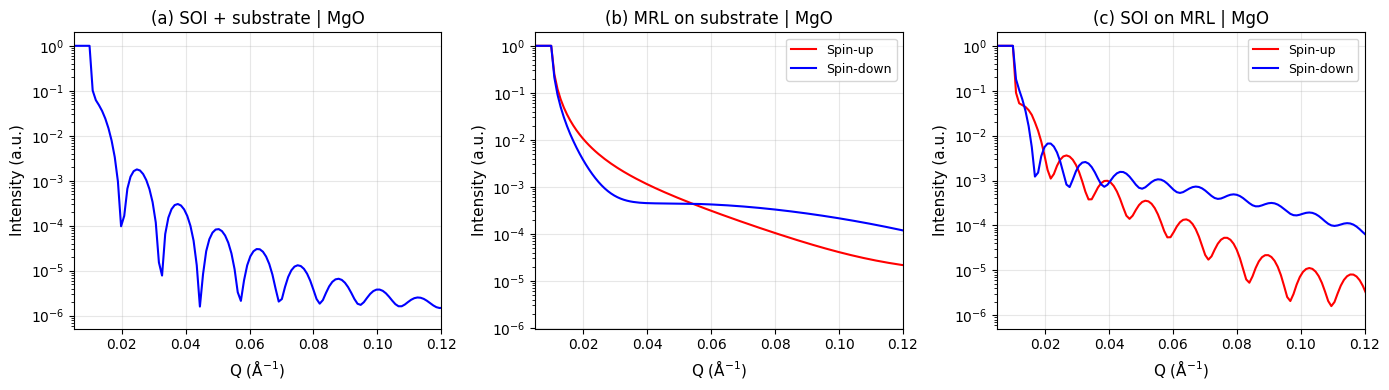

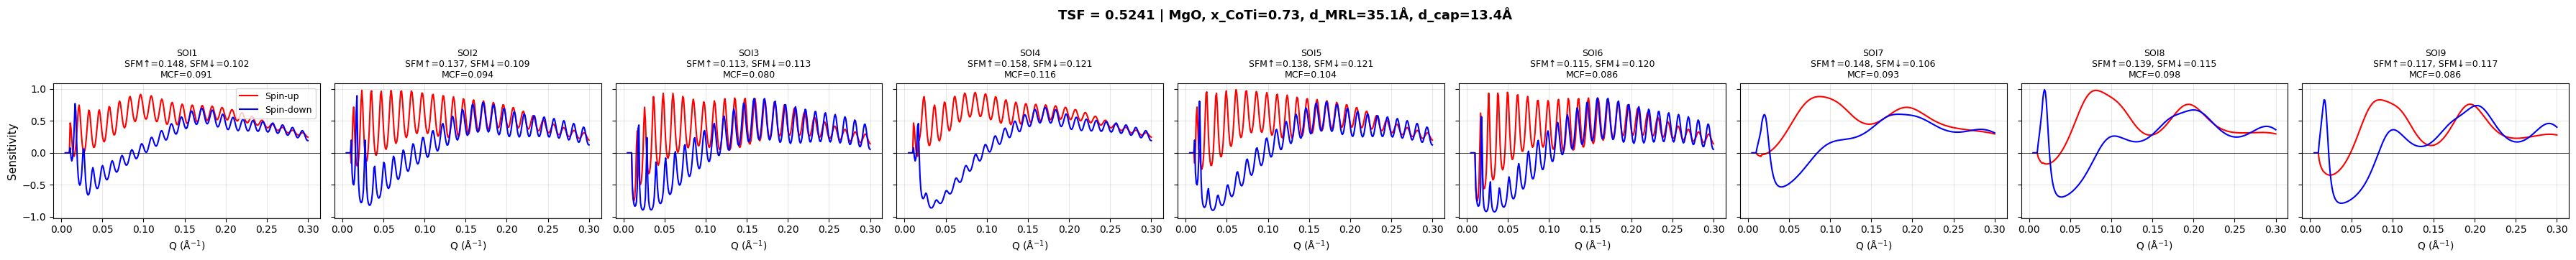


Plotting: Au (TSF=0.1709, d_MRL=34.7Å, d_cap=16.1Å)


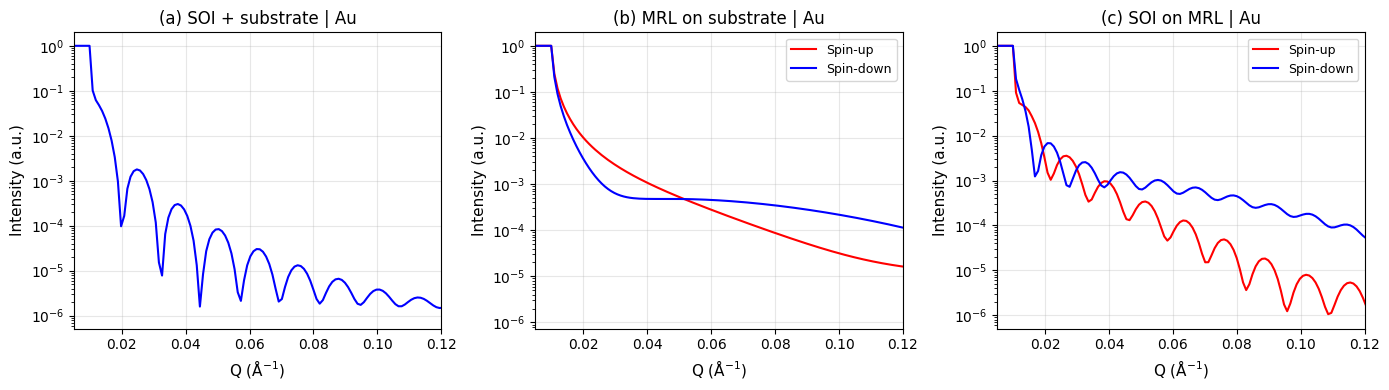

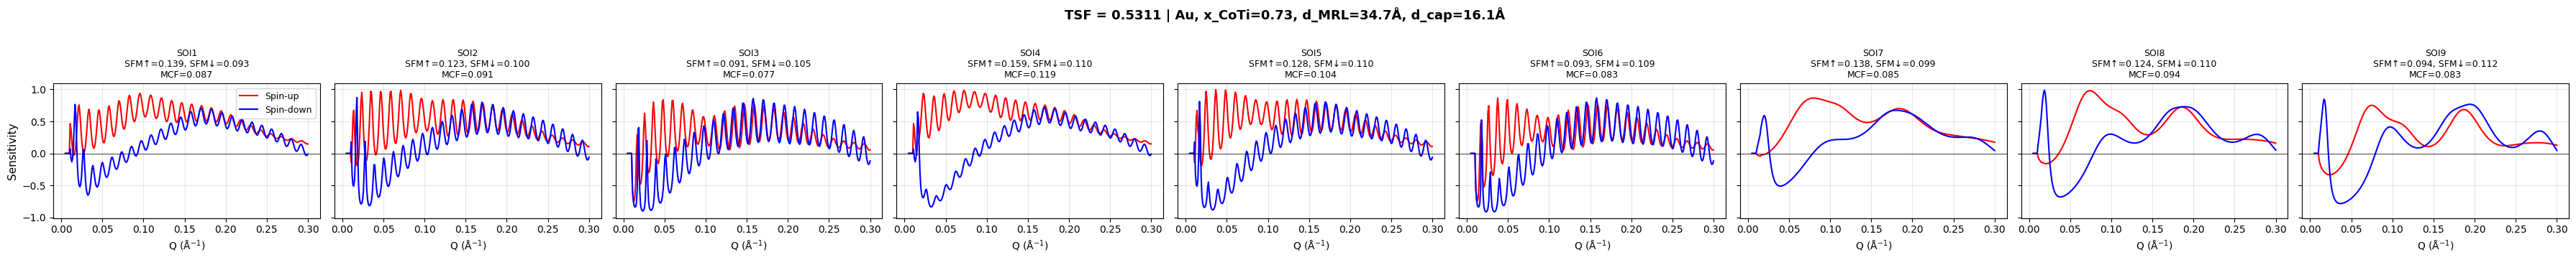


Plotting: TiO2_rutile (TSF=0.1661, d_MRL=34.5Å, d_cap=18.6Å)


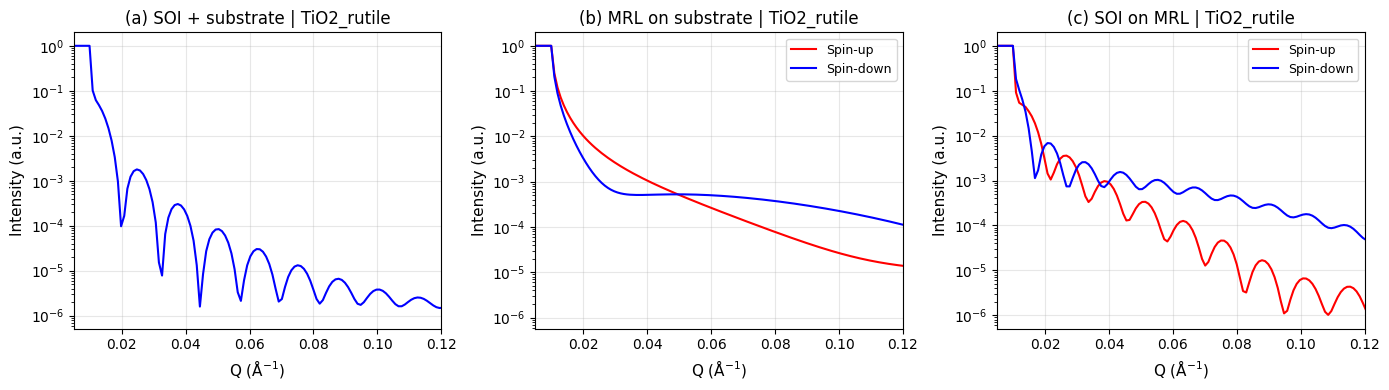

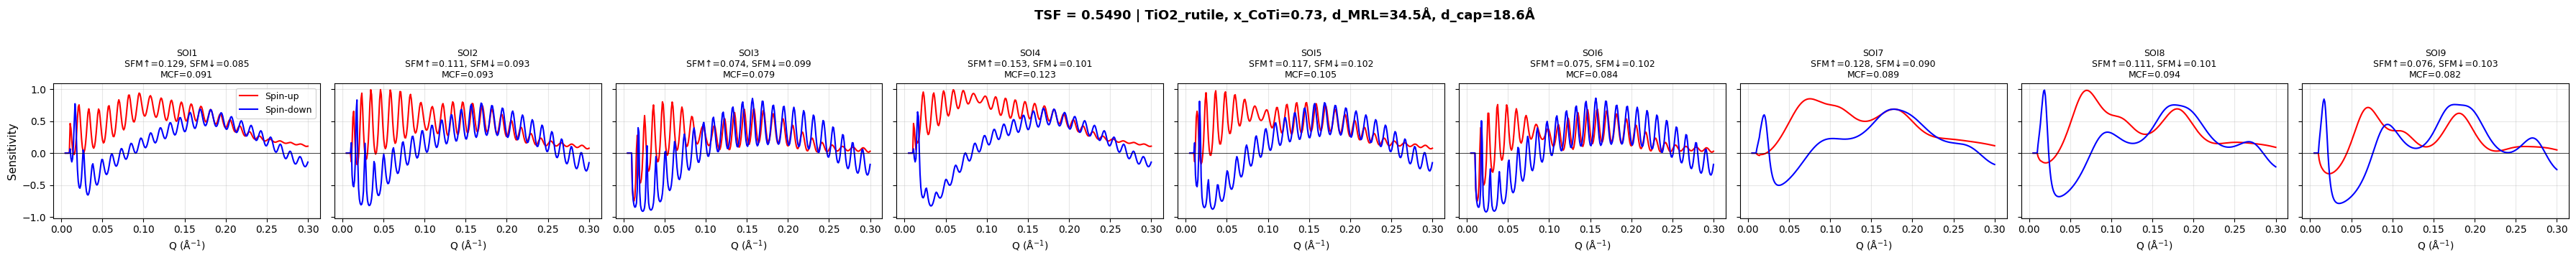

In [11]:
def plot_reflectivity_panels(problem, soi, x_coti, d_mrl, d_cap, cap, bkg=1e-6, title_suffix=""):
    """Plot 3-panel reflectivity view matching build.ipynb style."""
    Q = problem.Q
    q_lo = float(Q.min())
    q_hi = float(min(0.12, Q.max()))

    # No MRL
    layers_np = problem.layers_no_mrl(soi)
    R_np = problem._reflect(Q, layers_np, bkg=bkg)

    # MRL only
    layers_mrl_up, layers_mrl_dn = problem._layers(
        x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, soi=None
    )
    R_mrl_up = problem._reflect(Q, layers_mrl_up, bkg=bkg)
    R_mrl_dn = problem._reflect(Q, layers_mrl_dn, bkg=bkg)

    # Full stack
    res = problem.analyze_single_soi(
        soi=soi, x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, bkg=bkg
    )

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

    # Panel (a)
    axes[0].semilogy(Q, R_np, 'b-', label="Non-polarized")
    axes[0].set_xlabel(r"Q (Å$^{-1}$)", fontsize=11)
    axes[0].set_ylabel("Intensity (a.u.)", fontsize=11)
    axes[0].set_title(f"(a) SOI + substrate{title_suffix}", fontsize=12)
    axes[0].set_xlim(q_lo, q_hi)
    axes[0].grid(True, alpha=0.3)

    # Panel (b)
    axes[1].semilogy(Q, R_mrl_up, 'r-', label="Spin-up")
    axes[1].semilogy(Q, R_mrl_dn, 'b-', label="Spin-down")
    axes[1].set_xlabel(r"Q (Å$^{-1}$)", fontsize=11)
    axes[1].set_ylabel("Intensity (a.u.)", fontsize=11)
    axes[1].set_title(f"(b) MRL on substrate{title_suffix}", fontsize=12)
    axes[1].legend(fontsize=9)
    axes[1].set_xlim(q_lo, q_hi)
    axes[1].grid(True, alpha=0.3)

    # Panel (c)
    axes[2].semilogy(Q, res["Rfull_up"], 'r-', label="Spin-up")
    axes[2].semilogy(Q, res["Rfull_dn"], 'b-', label="Spin-down")
    axes[2].set_xlabel(r"Q (Å$^{-1}$)", fontsize=11)
    axes[2].set_ylabel("Intensity (a.u.)", fontsize=11)
    axes[2].set_title(f"(c) SOI on MRL{title_suffix}", fontsize=12)
    axes[2].legend(fontsize=9)
    axes[2].set_xlim(q_lo, q_hi)
    axes[2].grid(True, alpha=0.3)

    fig.tight_layout()
    return fig

def plot_sensitivity_grid(problem, x_coti, d_mrl, d_cap, cap, soi_list, bkg=1e-6):
    """Plot sensitivity for all SOIs with TSF score."""
    n = len(soi_list)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 3.5), sharex=True, sharey=True)
    axes = [axes] if n == 1 else list(axes)

    triplets = []
    for ax, soi in zip(axes, soi_list):
        res = problem.analyze_single_soi(
            soi=soi, x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, cap=cap, bkg=bkg
        )
        Q = res["Q"]
        S_up = res["S_up"]
        S_dn = res["S_dn"]

        ax.plot(Q, S_up, 'r-', label="Spin-up", linewidth=1.5)
        ax.plot(Q, S_dn, 'b-', label="Spin-down", linewidth=1.5)
        ax.axhline(0.0, color="k", linewidth=0.5)
        ax.set_xlabel(r"Q (Å$^{-1}$)", fontsize=10)
        ax.set_title(
            f"{soi.name}\n"
            f"SFM↑={res['SFM_up']:.3f}, SFM↓={res['SFM_dn']:.3f}\n"
            f"MCF={res['MCF']:.3f}",
            fontsize=9
        )
        ax.grid(True, alpha=0.3)
        triplets.append((res["SFM_up"], res["SFM_dn"], res["MCF"]))

    axes[0].set_ylabel("Sensitivity", fontsize=11)
    axes[0].legend(fontsize=9, loc="upper right")

    row_tsf = tsf(triplets)
    fig.suptitle(
        f"TSF = {row_tsf:.4f} | {cap}, x_CoTi={x_coti:.2f}, "
        f"d_MRL={d_mrl:.1f}Å, d_cap={d_cap:.1f}Å",
        fontsize=13, fontweight='bold', y=1.02
    )
    fig.tight_layout()
    return fig

# Generate plots for all materials
for res in results_log:
    cap_name = res["cap"]
    d_mrl = res["d_mrl"]
    d_cap = res["d_cap"]
    x_coti = res["x_coti"]
    score = res["score_final"]
    
    print(f"\n{'='*80}")
    print(f"Plotting: {cap_name} (TSF={score:.4f}, d_MRL={d_mrl:.1f}Å, d_cap={d_cap:.1f}Å)")
    print(f"{'='*80}")
    
    # Reflectivity panels (using 'build_like' SOI)
    target_soi = next((s for s in soi_list if s.name == "build_like"), soi_list[0])
    plot_reflectivity_panels(
        problem=problem, soi=target_soi, x_coti=x_coti, 
        d_mrl=d_mrl, d_cap=d_cap, cap=cap_name, title_suffix=f" | {cap_name}"
    )
    plt.show()
    
    # Sensitivity grid
    plot_sensitivity_grid(
        problem=problem, x_coti=x_coti, d_mrl=d_mrl, d_cap=d_cap, 
        cap=cap_name, soi_list=soi_list
    )
    plt.show()

## Summary

### Optimized Parameters
See results above for:
- Best capping material
- Optimal MRL thickness
- Optimal cap thickness
- Fixed Co:Ti ratio (73:27)

### Parameter Meanings

**Material Properties**:
- `rho_n`: Nuclear scattering length density - how strongly neutrons scatter from atomic nuclei
- `m_sld`: Magnetic scattering length density - how strongly neutrons scatter from magnetic moments
- `sigma`: Interface roughness - affects reflectivity oscillations

**Optimization Variables**:
- `x_CoTi`: Cobalt fraction in MRL (0=pure Ti, 1=pure Co) - **FIXED at 0.73**
- `d_mrl`: MRL thickness - **OPTIMIZED**
- `d_cap`: Capping layer thickness - **OPTIMIZED**

**Performance Metrics**:
- `SFM` (Squared Fringe Metric): Quantifies oscillation amplitude
- `MCF` (Mean Contrast Factor): Average spin contrast
- `TSF` (Total Squared Fringe): Sum of squared metrics across SOIs

### Important Notes

1. **Layer Structure is Fixed**: The order Si => MRL => Cap => SOI is defined in the `Base1OptimizationProblem` class and cannot be changed by users. This structure is based on experimental constraints for PNR measurements.

2. **Two-Stage Optimization**: Using evolutionary algorithm first ensures we find the global optimum region, then L-BFGS-B refines to high precision.

3. **Fixed Composition**: The Co:Ti ratio is fixed at 0.73 as specified in the original `Solver.ipynb`. To optimize composition as well, simply remove the `FIXED_X_COTI` constraint and add `x_coti` to the optimization variables.

4. **Universal Design**: The optimization finds a **single** MRL/cap structure that works well for **all** SOI types in the list.

# ============== EXTRA ===============

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, minimize
import time

sys.path.append(os.path.abspath("../"))

from problems.base1 import Base1OptimizationProblem, Materials, MRL, Bounds, SOISpec, CapSpec, SubstrateSpec
from physics.fom import tsf
from physics.reflectometry import reflectivity as refl
from physics.magnetic_sld import coti_magnetic_sld

# Setup materials
sub = SubstrateSpec(
    name="Si",
    rho_n=2.07,
    sigma=3.0
)

# Best performing capping materials from earlier optimization
caps = {
    "MgO":          CapSpec(name="MgO",          nom_thickness=50.0, rho_n=5.38, sigma=3.0),
    "Au":           CapSpec(name="Au",           nom_thickness=50.0, rho_n=4.5,  sigma=3.0),
    "TiO2_rutile":  CapSpec(name="TiO2_rutile",  nom_thickness=50.0, rho_n=4.08, sigma=3.0),
}

# MRL definition
mrl = MRL(
    rho_n_Co=1.21,
    rho_n_Ti=-1.94,
    m_sld_from_x=coti_magnetic_sld, 
    sigma_sub_mrl=5.0,
    sigma_mrl_cap=5.0
)

materials = Materials(substrate=sub, caps=caps, mrl=mrl)

# SOI definitions
soi_list = [
    # Normal Type: Thickness 500 A, Roughness 15 A
    SOISpec(name="SOI1", rho_n=1.0, thickness=500.0, sigma=15.0),
    SOISpec(name="SOI2", rho_n=2.0, thickness=500.0, sigma=15.0),
    SOISpec(name="SOI3", rho_n=3.0, thickness=500.0, sigma=15.0),

    # Rough Type: Thickness 500 A, Roughness 50 A
    SOISpec(name="SOI4", rho_n=1.0, thickness=500.0, sigma=50.0),
    SOISpec(name="SOI5", rho_n=2.0, thickness=500.0, sigma=50.0),
    SOISpec(name="SOI6", rho_n=3.0, thickness=500.0, sigma=50.0),

    # Thin Type: Thickness 50 A, Roughness 15 A
    SOISpec(name="SOI7", rho_n=1.0, thickness=50.0, sigma=15.0),
    SOISpec(name="SOI8", rho_n=2.0, thickness=50.0, sigma=15.0),
    SOISpec(name="SOI9", rho_n=3.0, thickness=50.0, sigma=15.0)
]

# Q-space grid
q_grid = np.linspace(0.005, 0.3, 300)

# Parameter bounds
bounds_x = Bounds(0, 1)          # Co fraction: 0 to 1 (NOW OPTIMIZED!)
bounds_d = Bounds(10, 1200)      # MRL thickness: 10 to 1200 Å
bounds_cap = Bounds(10, 200)     # Cap thickness: 10 to 200 Å

# Create optimization problem
problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=soi_list,
    q_grid=q_grid,
    bounds_x=bounds_x,
    bounds_d=bounds_d,
    bounds_cap=bounds_cap
)

# Optimization settings
TIME_BUDGET_S = 2 * 60  # 2 minutes per material
SEED = 42               # For reproducibility

# Storage for results
results_log = []
best_overall = {"score": -np.inf, "cap": None, "d_mrl": 0, "d_cap": 0, "x_coti": 0}

print("="*80)
print("THREE-PARAMETER OPTIMIZATION (INCLUDING CoTi RATIO)")
print("="*80)
print(f"Capping materials to test: {len(caps)}")
print(f"Time budget per material: {TIME_BUDGET_S/60:.0f} minutes")
print("\nOptimizing:")
print("  - MRL thickness (d_mrl)")
print("  - Capping layer thickness (d_cap)")
print("  - Co:Ti composition ratio (x_coti) <-- NOW OPTIMIZED!")
print("\nStage 1: Differential Evolution (global search)")
print("Stage 2: L-BFGS-B (local refinement)")
print("="*80)

# Run optimization for each capping material
for cap_name in caps.keys():
    print(f"\n{'='*80}")
    print(f"Optimizing for capping material: {cap_name}")
    print(f"{'='*80}")
    
    # Objective function (minimize negative TSF = maximize TSF)
    def objective_func(x):
        x_coti_val, d_mrl_val, d_cap_val = x
        score = problem.evaluate_objective(
            x_coti=float(x_coti_val),
            d_mrl=float(d_mrl_val),
            d_cap=float(d_cap_val),
            cap=cap_name
        )
        return -float(score)  # Negative for minimization
    
    # Parameter bounds (NOW INCLUDING x_coti!)
    bnds = [
        (bounds_x.lo, bounds_x.hi),      # Co fraction (0 to 1)
        (bounds_d.lo, bounds_d.hi),      # MRL thickness
        (bounds_cap.lo, bounds_cap.hi),  # Cap thickness
    ]
    
    # Differential Evolution
    print("\n[Stage 1] Differential Evolution (global search)...")
    start_time = time.monotonic()
    
    def stop_if_time_up(xk, convergence):
        return (time.monotonic() - start_time) > TIME_BUDGET_S
    
    de_result = differential_evolution(
        objective_func,
        bounds=bnds,
        strategy="best1bin",
        maxiter=10000,
        popsize=25,
        tol=0.0,
        mutation=(0.5, 1.0),
        recombination=0.7,
        seed=SEED,
        polish=False,
        updating="deferred",
        workers=1,
        callback=stop_if_time_up,
        disp=False
    )
    
    de_score = -float(de_result.fun)
    x_coti_de, d_mrl_de, d_cap_de = map(float, de_result.x)
    de_time = time.monotonic() - start_time
    
    print(f"  Completed in {de_time:.1f}s")
    print(f"  DE Score: {de_score:.6f}")
    print(f"  DE Params: x_coti={x_coti_de:.4f} ({x_coti_de*100:.1f}% Co), d_mrl={d_mrl_de:.2f} Å, d_cap={d_cap_de:.2f} Å")
    
    # L-BFGS-B
    print("\n[Stage 2] L-BFGS-B (local refinement)...")
    lbfgs_start = time.monotonic()
    
    lbfgs_result = minimize(
        objective_func,
        x0=de_result.x,
        method="L-BFGS-B",
        bounds=bnds,
        options={"maxiter": 5000, "ftol": 1e-12, "gtol": 1e-10}
    )
    
    lbfgs_time = time.monotonic() - lbfgs_start
    final_score = -float(lbfgs_result.fun)
    x_coti_final, d_mrl_final, d_cap_final = map(float, lbfgs_result.x)
    
    print(f"  Completed in {lbfgs_time:.1f}s")
    print(f"  Final Score: {final_score:.6f} (Δ = {final_score - de_score:.6f})")
    print(f"  Final Params: x_coti={x_coti_final:.4f} ({x_coti_final*100:.1f}% Co), d_mrl={d_mrl_final:.2f} Å, d_cap={d_cap_final:.2f} Å")
    
    # Store results
    results_log.append({
        "cap": cap_name,
        "score_de": de_score,
        "score_final": final_score,
        "x_coti": x_coti_final,
        "d_mrl": d_mrl_final,
        "d_cap": d_cap_final,
        "time_de": de_time,
        "time_lbfgs": lbfgs_time
    })
    
    # Update best overall
    if final_score > best_overall["score"]:
        best_overall = {
            "score": final_score,
            "cap": cap_name,
            "x_coti": x_coti_final,
            "d_mrl": d_mrl_final,
            "d_cap": d_cap_final
        }

print(f"\n\n{'='*80}")
print("OPTIMIZATION COMPLETE")
print(f"{'='*80}")
print(f"Best capping material: {best_overall['cap']}")
print(f"Best TSF score: {best_overall['score']:.6f}")
print(f"Optimal Co:Ti ratio: {best_overall['x_coti']:.4f} ({best_overall['x_coti']*100:.1f}% Co)")
print(f"Optimal MRL thickness: {best_overall['d_mrl']:.2f} Å")
print(f"Optimal cap thickness: {best_overall['d_cap']:.2f} Å")
print(f"{'='*80}")

# Print comparison table
print("\n\nComparison with fixed Co:Ti ratio (0.73):")
print("="*100)
print(f"{'Rank':<6} {'Material':<15} {'Final TSF':<12} {'x_CoTi':<12} {'MRL (Å)':<10} {'Cap (Å)':<10}")
print("="*100)

# Sort by score
results_sorted = sorted(results_log, key=lambda x: x['score_final'], reverse=True)
for i, row in enumerate(results_sorted, 1):
    print(f"{i:<6} {row['cap']:<15} {row['score_final']:<12.6f} {row['x_coti']:.4f} ({row['x_coti']*100:.1f}%)  {row['d_mrl']:<10.2f} {row['d_cap']:<10.2f}")

print("="*100)
print("\nNote: The fixed Co:Ti optimization used x_coti = 0.73 (73% Co)")
print("      Compare these results to see if optimizing the ratio improves performance")


THREE-PARAMETER OPTIMIZATION (INCLUDING CoTi RATIO)
Capping materials to test: 3
Time budget per material: 2 minutes

Optimizing:
  - MRL thickness (d_mrl)
  - Capping layer thickness (d_cap)
  - Co:Ti composition ratio (x_coti) <-- NOW OPTIMIZED!

Stage 1: Differential Evolution (global search)
Stage 2: L-BFGS-B (local refinement)

Optimizing for capping material: MgO

[Stage 1] Differential Evolution (global search)...
  Completed in 120.1s
  DE Score: 0.197443
  DE Params: x_coti=1.0000 (100.0% Co), d_mrl=31.39 Å, d_cap=15.71 Å

[Stage 2] L-BFGS-B (local refinement)...
  Completed in 0.1s
  Final Score: 0.197443 (Δ = 0.000000)
  Final Params: x_coti=1.0000 (100.0% Co), d_mrl=31.39 Å, d_cap=15.71 Å

Optimizing for capping material: Au

[Stage 1] Differential Evolution (global search)...
  Completed in 120.0s
  DE Score: 0.185176
  DE Params: x_coti=1.0000 (100.0% Co), d_mrl=31.19 Å, d_cap=19.50 Å

[Stage 2] L-BFGS-B (local refinement)...
  Completed in 0.1s
  Final Score: 0.185176 (Δ